<a href="https://colab.research.google.com/github/aoran1102/aoran1102.github.io/blob/master/team_performance_deep_dive_in_nba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Performance Exploration in NBA

# Background


In this exploration, we delved into a dataset rich with variables that provide a deeper understanding of NBA games. Our aim is to leverage this information to unearth insights and discern the underlying rootcauses if possible.

# Part 0: Setup Google Drive Environment & Load Data

In [ ]:
import pandas as pd
import numpy as np

from tabulate import tabulate


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# correlation heat map of numerical features
import seaborn as sns
import matplotlib.pyplot as plt

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=14sQajTBOTXz8PJ29gS_okGlZ3L4AdVkW'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id})
file.GetContentFile('nbaallelo.csv.csv')
nba  = pd.read_csv('nbaallelo.csv.csv')

# Part 1 Basic Information


The dataset contains 126k records acorss 53 teams(teams with same fran_id were considered the same team) from 1947 to 2015, with only 6% of the games classified as playoffs. It features 23 variables, 13 of which are numeric. There are no missing values in any of the variables.

In [ ]:
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126314 entries, 0 to 126313
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   gameorder      126314 non-null  int64  
 1   game_id        126314 non-null  object 
 2   lg_id          126314 non-null  object 
 3   _iscopy        126314 non-null  int64  
 4   year_id        126314 non-null  int64  
 5   date_game      126314 non-null  object 
 6   seasongame     126314 non-null  int64  
 7   is_playoffs    126314 non-null  int64  
 8   team_id        126314 non-null  object 
 9   fran_id        126314 non-null  object 
 10  pts            126314 non-null  int64  
 11  elo_i          126314 non-null  float64
 12  elo_n          126314 non-null  float64
 13  win_equiv      126314 non-null  float64
 14  opp_id         126314 non-null  object 
 15  opp_fran       126314 non-null  object 
 16  opp_pts        126314 non-null  int64  
 17  opp_elo_i      126314 non-nul

In [ ]:
# check missing values
nba.isnull().sum()

gameorder             0
game_id               0
lg_id                 0
_iscopy               0
year_id               0
date_game             0
seasongame            0
is_playoffs           0
team_id               0
fran_id               0
pts                   0
elo_i                 0
elo_n                 0
win_equiv             0
opp_id                0
opp_fran              0
opp_pts               0
opp_elo_i             0
opp_elo_n             0
game_location         0
game_result           0
forecast              0
notes            120890
dtype: int64

In [ ]:
#numeric summary
nba.describe()

,gameorder,_iscopy,year_id,seasongame,is_playoffs,pts,elo_i,elo_n,win_equiv,opp_pts,opp_elo_i,opp_elo_n,forecast
count,126314.000000,126314.000000,126314.000000,126314.000000,126314.000000,126314.000000,126314.000000,126314.000000,126314.000000,126314.000000,126314.000000,126314.000000,126314.000000
mean,31579.000000,0.500000,1988.200374,43.533733,0.063857,102.729982,1495.236055,1495.236055,41.707889,102.729982,1495.236055,1495.236055,0.500000
std,18231.927643,0.500002,17.582309,25.375178,0.244499,14.814845,112.139945,112.461687,10.627332,14.814845,112.139945,112.461687,0.215252
min,1.000000,0.000000,1947.000000,1.000000,0.000000,0.000000,1091.644500,1085.774400,10.152501,0.000000,1091.644500,1085.774400,0.020447
25%,15790.000000,0.000000,1975.000000,22.000000,0.000000,93.000000,1417.237975,1416.994900,34.103035,93.000000,1417.237975,1416.994900,0.327989
50%,31579.000000,0.500000,1990.000000,43.000000,0.000000,103.000000,1500.945550,1500.954400,42.113357,103.000000,1500.945550,1500.954400,0.500000
75%,47368.000000,1.000000,2003.000000,65.000000,0.000000,112.000000,1576.060000,1576.291625,49.635328,112.000000,1576.060000,1576.291625,0.672011
max,63157.000000,1.000000,2015.000000,108.000000,1.000000,186.000000,1853.104500,1853.104500,71.112038,186.000000,1853.104500,1853.104500,0.979553


In [ ]:
#onject summary
nba.describe(include = object)

,game_id,lg_id,date_game,team_id,fran_id,opp_id,opp_fran,game_location,game_result,notes
count,126314,126314,126314,126314,126314,126314,126314,126314,126314,5424
unique,63157,2,12426,104,53,104,53,3,2,231
top,194611010TRH,NBA,4/13/2011,BOS,Lakers,BOS,Lakers,H,L,at New York NY
freq,2,118016,30,5997,6024,5997,6024,63138,63157,440


In [ ]:
# date range
nba['date_game'] = pd.to_datetime(nba['date_game'])

In [ ]:
nba['is_playoffs'].sum()/len(nba['is_playoffs'])

0.06385673797045457

# Part 2 Performance Exploration

## 2.1 Top Winning Teams in the nearest 5 years


From 2011 - 2015, the Spurs, Heat, Thunder, Bulls, and Grizzlies were the top winning team and they maintained a win rate exceeding 60% across roughly 400 games, demonstrating consistent performance rather than sporadic success.

The performance of these 5 teams varied over time:





*   The Spurs consistently performed well since 1990.
*   The win rates of the Heat and the Grizzlies improved over time, indicating steady progress. This improvement was likely due to better management & leadership,  key player acquisitions, and effective player development.



* The Thunder and the Bulls peaked between 1990 and 2000, after which their performance declined, likely due to the departure of key players and coaches, such as Michael Jordan and Coach Phil Jackson. Although they improved after 2010, they have not fully returned to their former levels.



In [ ]:
# get win rates
win_loss_counts = nba[(nba['year_id'] >= 2011) & (nba['is_playoffs'] == 0)].groupby('fran_id')['game_result'].value_counts(normalize=True).unstack()
win_rates = win_loss_counts['W'].sort_values(ascending=False)

In [ ]:
# top 5 best winning teams
win_rates.head()

fran_id
Spurs        0.725888
Thunder      0.675127
Heat         0.662437
Bulls        0.647208
Grizzlies    0.629442
Name: W, dtype: float64

In [ ]:
#games teams played
nba[(nba['year_id'] >= 2011) &  (nba['is_playoffs'] == 0) & (nba['fran_id'].isin(['Spurs', 'Heat', 'Thunder', 'Bulls', 'Grizzlies']))].groupby('fran_id')['game_result'].count()

fran_id
Bulls        394
Grizzlies    394
Heat         394
Spurs        394
Thunder      394
Name: game_result, dtype: int64

In [ ]:
# top 5 games win rate over time
win_loss_counts_by_year = nba[(nba['fran_id'].isin(['Spurs', 'Heat', 'Thunder', 'Bulls', 'Grizzlies'])) & (nba['is_playoffs'] == 0)].groupby(['fran_id','year_id'])['game_result'].value_counts(normalize=True).unstack()

In [ ]:
win_loss_counts_by_year.reset_index(inplace = True)

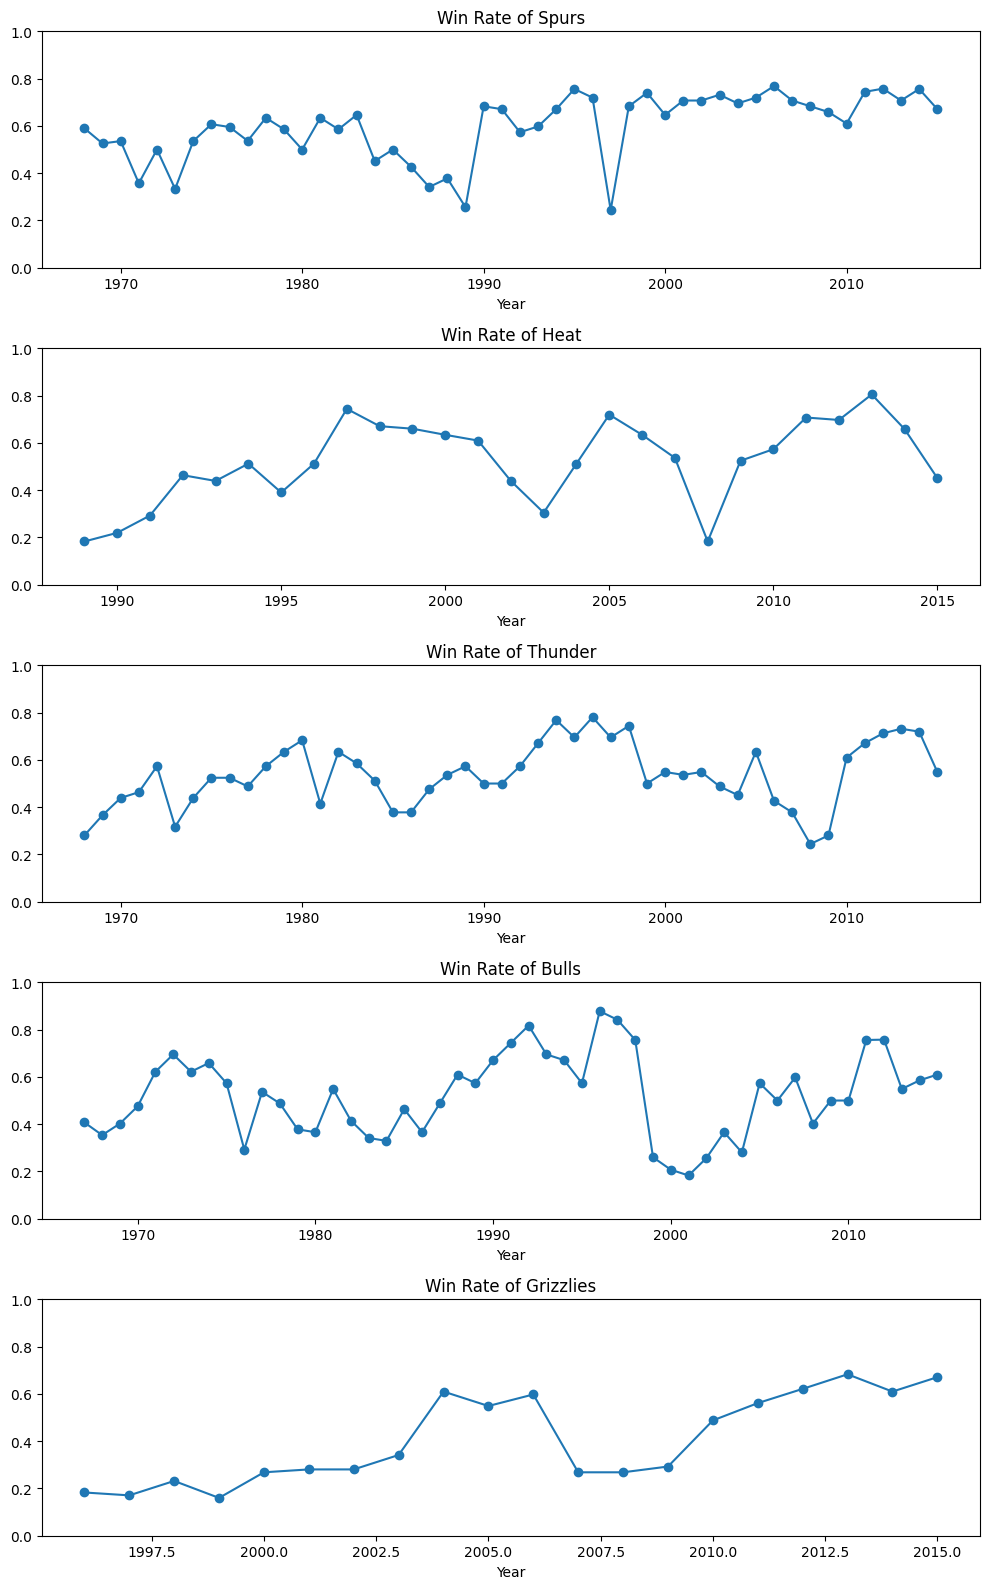

In [ ]:
# visualize win rate over time
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 16))
axes_flat = axes.flatten()


for i, fran_id in enumerate(['Spurs', 'Heat', 'Thunder', 'Bulls', 'Grizzlies']):
    ax = axes_flat[i]
    ax.plot(win_loss_counts_by_year[win_loss_counts_by_year['fran_id'] == fran_id]['year_id'], win_loss_counts_by_year[win_loss_counts_by_year['fran_id'] == fran_id]['W'], marker='o')
    ax.set_title(f'Win Rate of {fran_id}', fontsize=12)
    ax.set_xlabel('Year')
    #ax.set_ylabel('Win Rate')
    ax.set_ylim(0, 1)
    ax.legend().set_visible(False)
plt.tight_layout()
plt.show()


## 2.2 Relationship between Win Rate Home or Away

whether the team was playing at home or away significantly influenced the game results. Teams generally had a significantly higher win rate when playing at home probably because of court advantage and boosting player morale from home crowd support.

In [ ]:
# get win rates by game location
game_results = nba[ (nba['is_playoffs'] == 0) & (nba['game_location'] != 'N')].groupby(['fran_id','game_location'])['game_result'].value_counts(normalize=True).unstack()
game_wins = game_results['W'].reset_index()
game_results_by_season = game_wins.pivot_table(
    index='fran_id',
    columns=['game_location'],
    values='W',
    aggfunc='mean'
)
game_results_by_season.reset_index(inplace = True)
game_results_by_season['win_rate_diff'] = game_results_by_season['H'] - game_results_by_season['A']

<Axes: title={'center': 'Boxplot of Win Rate Difference: Home vs. Away'}>

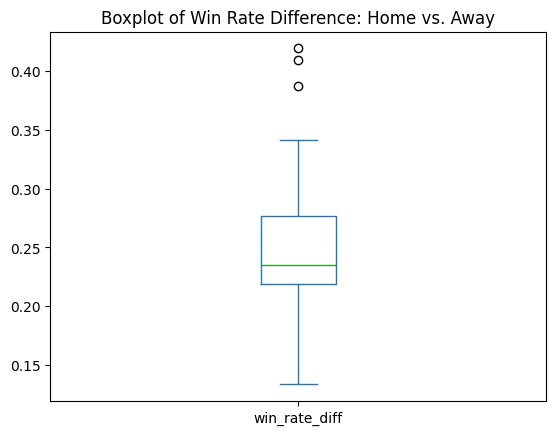

In [ ]:
game_results_by_season['win_rate_diff'].plot.box(title='Boxplot of Win Rate Difference: Home vs. Away')


## 2.3 How ELO Score Changed after Games?


The distribution of the score change approximating a normal distribution indicated that drastic changes in Elo ratings(defeating a much higher-rated opponent or losing to a much lower-rated one) rarely happened. This suggested that most games resulted in rating changes close to the mean, reflecting a balance in competitive matchups and consistent performance expectations based on team ratings.

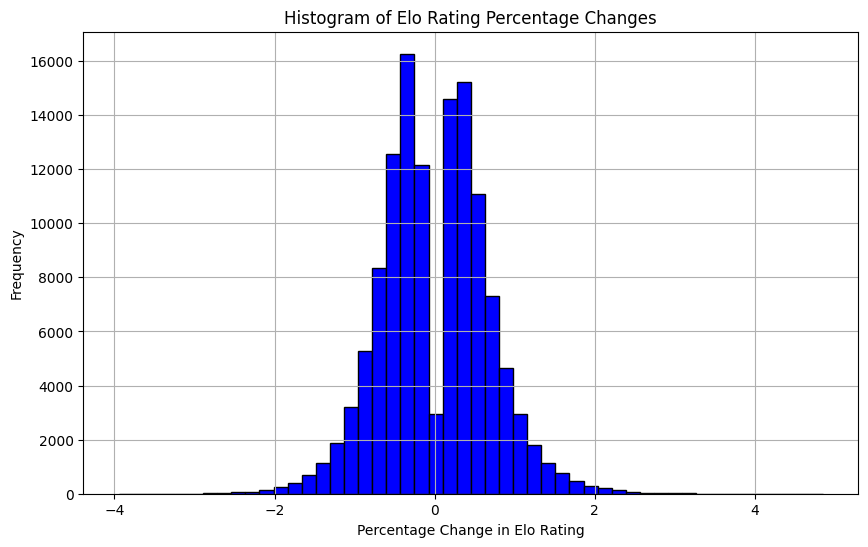

In [ ]:
nba['elo_change'] = (nba['elo_n'] - nba['elo_i'])/nba['elo_i']
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(nba['elo_change'] * 100, bins=50, color='blue', edgecolor='black')  # Multiply by 100 for percentage
plt.title('Histogram of Elo Rating Percentage Changes')
plt.xlabel('Percentage Change in Elo Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()